In [116]:
import tensorflow as tf
import numpy as np
import os
import time
import regex as re
import subprocess
import urllib
import functools

import torch.distributions.distribution
from IPython import display as ipythondisplay
from tqdm import tqdm
import matplotlib.pyplot as plt

from Graph import PeriodicPlotter
from LSTM_Model import *

In [117]:
def save_song_to_abc(song, filename="sampleFromDataset"):
    save_name = os.path.join(op, "{}.abc".format(filename))
    with open(save_name, "w") as f:
        f.write(song)
    return filename

def abc2wav(abc_file):
    suf = abc_file.rstrip('.abc')
    print(abc_file)
    cmd = "abc2midi {} -o {}".format(abc_file, suf + ".mid")
    os.system(cmd)
    #can't write to file.. tmp.mid is not a midi file. We will just save the wav file as the name of the mid file
    #cmd = "timidity {}.mid -Ow {}.wav".format(suf, suf)
    cmd = "timidity {}.mid -Ow".format(suf, suf)
    return os.system(cmd)

def play_wav(wav_file):
    return ipythondisplay.Audio(wav_file)

def play_song(song):
    basename = os.path.join(op, save_song_to_abc(song))
    ret = abc2wav(basename + '.abc')
    if ret == 0:  # did not suceed
        return play_wav(basename + '.wav')
    return None

def extract_song_snippet(text):
    pattern = '(^|\n\n)(.*?)\n\n'
    search_results = re.findall(pattern, text, overlapped=True, flags=re.DOTALL)
    songs = [song[1] for song in search_results]
    print("Found {} songs in text".format(len(songs)))
    return songs


In [118]:
# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
# assert len(tf.config.list_physical_devices('GPU')) > 0

train = True
songs = []

In [119]:
#current directory
cwd = os.getcwd()
#collection of all outputs directory
opd = os.path.join(cwd, "test_outputs")
#output directory for this generation

op = os.path.join(opd, "output@"+time.asctime().replace(' ', '').replace(':', ''))

#create directories
try:
    os.mkdir(opd)
except FileExistsError:
    print("The test_outputs directory already exists...")

try:
    os.mkdir(op)
except FileExistsError:
    print("The directory {} already exists...".format(op))

In [120]:
with open(os.path.join(cwd, 'dataset', 'irish.abc'), 'r') as f:
    text = f.read()
    songs = extract_song_snippet(text)

# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)

# need abc2midi and timidity
play_song(example_song)

Found 818 songs in text

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!
C:\Users\pecko\PycharmProjects\MusicGenerator\test_outputs\output@ThuMar100241422022\sampleFromDataset.abc


In [121]:
# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs)

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

### Define numerical representation of text ###

# Create a mapping from character to unique index.
# For example, to get the index of the character "d",
#   we can evaluate `char2idx["d"]`.
char2idx = {u: i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)  ### Define numerical representation of text ###

# Create a mapping from character to unique index.
# For example, to get the index of the character "d",
#   we can evaluate `char2idx["d"]`.
char2idx = {u: i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)

print('{')
for char, _ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

### Vectorize the songs string ###

'''TODO: Write a function to convert the all songs string to a vectorized
    (i.e., numeric) representation. Use the appropriate mapping
    above to convert from vocab characters to the corresponding indices.

  NOTE: the output of the `vectorize_string` function
  should be a np.array with `N` elements, where `N` is
  the number of characters in the input string
'''


def vectorize_string(string):
    vectorized_list = np.array([char2idx[s] for s in string])
    return vectorized_list


vectorized_songs = vectorize_string(songs_joined)

print('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"


def test_batch_func_types(func, args):
    ret = func(*args)
    assert len(ret) == 2, "[FAIL] get_batch must return two arguments (input and label)"
    assert type(ret[0]) == np.ndarray, "[FAIL] test_batch_func_types: x is not np.array"
    assert type(ret[1]) == np.ndarray, "[FAIL] test_batch_func_types: y is not np.array"
    print("[PASS] test_batch_func_types")
    return True


def test_batch_func_shapes(func, args):
    dataset, seq_length, batch_size = args
    x, y = func(*args)
    correct = (batch_size, seq_length)
    assert x.shape == correct, "[FAIL] test_batch_func_shapes: x {} is not correct shape {}".format(x.shape, correct)
    assert y.shape == correct, "[FAIL] test_batch_func_shapes: y {} is not correct shape {}".format(y.shape, correct)
    print("[PASS] test_batch_func_shapes")
    return True


def test_batch_func_next_step(func, args):
    x, y = func(*args)
    assert (x[:, 1:] == y[:, :-1]).all(), "[FAIL] test_batch_func_next_step: x_{t} must equal y_{t-1} for all t"
    print("[PASS] test_batch_func_next_step")
    return True


### Batch definition to create training examples ###

def get_batch(vectorized_songs, seq_length, batch_size):
    # the length of the vectorized songs string
    n = vectorized_songs.shape[0] - 1
    # randomly choose the starting indices for the examples in the training batch
    idx = np.random.choice(n - seq_length, batch_size)

    '''TODO: construct a list of input sequences for the training batch'''
    input_batch = [vectorized_songs[i:i + seq_length] for i in idx]
    '''TODO: construct a list of output sequences for the training batch'''
    output_batch = [vectorized_songs[i + 1: i + 1 + seq_length] for i in idx]

    # x_batch, y_batch provide the true inputs and targets for network training
    x_batch = np.reshape(input_batch, [batch_size, seq_length])
    y_batch = np.reshape(output_batch, [batch_size, seq_length])
    return x_batch, y_batch

There are 83 unique characters in the dataset
{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}
'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


In [122]:
# Perform some simple tests to make sure your batch function is working properly!
test_args = (vectorized_songs, 10, 2)
if not test_batch_func_types(get_batch, test_args) or \
        not test_batch_func_shapes(get_batch, test_args) or \
        not test_batch_func_next_step(get_batch, test_args):
    print("======\n[FAIL] could not pass tests")
else:
    print("======\n[PASS] passed all tests!")

x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!
Step   0
  input: 60 ('e')
  expected output: 56 ('a')
Step   1
  input: 56 ('a')
  expected output: 62 ('g')
Step   2
  input: 62 ('g')
  expected output: 60 ('e')
Step   3
  input: 60 ('e')
  expected output: 1 (' ')
Step   4
  input: 1 (' ')
  expected output: 59 ('d')


In [123]:
# Build a simple model with default hyperparameters. You will get the
#   chance to change these later.
#model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=4)
model = MusicGenerator(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=4, seq_length=100)

print(model)
#model.summary()

x, y = get_batch(vectorized_songs, seq_length=100, batch_size=4)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

#sampled_indices = tf.random.categorical(pred[0], num_samples=1)
#sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
sampled_indices = torch.distributions.categorical.Categorical(logits=pred[0]).sample()
sampled_indices = torch.squeeze(sampled_indices, dim=-1).numpy()

print("Input: \n", repr("".join(idx2char[x[0]])))
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

MusicGenerator(
  (lstm_model): Sequential(
    (0): Embedding(400, 256)
    (1): LSTM(256, 1024, batch_first=True)
    (2): GetLSTMOutput()
    (3): Linear(in_features=1024, out_features=83, bias=True)
  )
)
Input shape:       (4, 100)  # (batch_size, sequence_length)
Prediction shape:  torch.Size([4, 100, 83]) # (batch_size, sequence_length, vocab_size)
Input: 
 'afd edB|dcd AFA|dcd ede|fef efg|!\nafd edB|dcd AFA|dcd efg|fdc d2:|!\ne|f3 g3|f3 fed|f3 g3|afd e2d|!\nf'
Next Char Predictions: 
 '1gy!:/SR0)zGye8.L>m\'Fa\'6SBOq yC8G k/q_/y\nw.\n0bQ92Ra>,Q6fUWKiV=B"k^l!ao"i5bgWFAYVwhB)a0rL4E!2Jh<>fj7('


In [124]:
### Defining the loss function ###

'''TODO: define the loss function to compute and return the loss between
    the true labels and predictions (logits). Set the argument from_logits=True.'''


def compute_loss(labels, logits):
    #loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits.detach().numpy(), from_logits=True)
    x = torch.Tensor(logits).permute((0, 2, 1))  # shape of preds must be (N, C, H, W) instead of (N, H, W, C)
    y = torch.Tensor(labels).long()  # shape of labels must be (N, H, W) and type must be long integer
    loss = torch.nn.CrossEntropyLoss()(x, y)
    return loss

'''TODO: compute the loss using the true next characters from the example batch
    and the predictions from the untrained model several cells above'''
example_batch_loss = compute_loss(y, pred)

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)")
'''
example_batch_loss.numpy().mean() = 4.417909
'''
print("scalar_loss:      ", example_batch_loss.detach().numpy().mean())

Prediction shape:  torch.Size([4, 100, 83])  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.417476


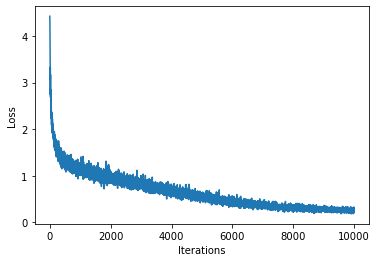

100%|██████████| 10000/10000 [4:14:32<00:00,  1.53s/it]


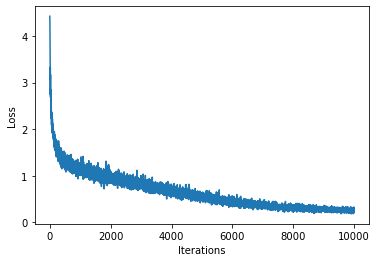

In [125]:
### Hyperparameter setting and optimization ###

epochs = 1

# Optimization parameters:
num_training_iterations = 10000  # Increase this to train longer
batch_size = 8  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 1e-1  # Experiment between 1e-5 and 1e-1

# Model parameters:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location:
checkpoint_dir = 'training_checkpoints_pytorch'
checkpoint_prefix = 'my_ckpt'

checkpoint_dir = os.path.join(cwd, checkpoint_dir)
#try to create pytorch training checkpoints directory
try:
    os.mkdir(checkpoint_dir)
except FileExistsError:
    print("The pytorch training directory already exists...")

checkpoint_prefix = os.path.join(checkpoint_dir, checkpoint_prefix)


### Define optimizer and training operation ###

'''TODO: instantiate a new model for training using the `build_model`
  function and the hyperparameters created above.'''
# model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
#model = MusicGenerator(vocab_size=len(vocab), embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=batch_size, seq_length=seq_length)
model = torch.nn.Sequential(
            torch.nn.Embedding(batch_size*seq_length, embedding_dim),
            torch.nn.LSTM(embedding_dim, rnn_units, batch_first=True),
            GetLSTMOutput(),
            torch.nn.Linear(rnn_units, vocab_size)
        )

'''TODO: instantiate an optimizer with its learning rate.
  Checkout the tensorflow website for a list of supported optimizers.
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Try using the Adam optimizer to start.'''
# optimizer = tf.keras.optimizers.Adam(learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

def torch_train(x, y):
    for epoch in range(epochs):
        # forward pass and loss calculation
        # implicit tape-based AD
        y_hat = model(torch.tensor(x))
        loss = compute_loss(y, y_hat)

        optimizer.zero_grad()
        # compute gradients (grad)
        loss.backward()
        optimizer.step()
        return loss

### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
    # Evaluation step (generating ABC text using the learned RNN model)

    '''TODO: convert the start string to numbers (vectorize)'''
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Here batch size == 1
    model.reset_states()
    tqdm._instances.clear()

    for i in tqdm(range(generation_length)):
        predictions = model(input_eval)

        # Remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        '''TODO: use a multinomial distribution to sample'''
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Pass the prediction along with the previous hidden state
        #   as the next inputs to the model
        input_eval = tf.expand_dims([predicted_id], 0)

        '''TODO: add the predicted character to the generated text!'''
        # Hint: consider what format the prediction is in vs. the output
        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))


##################
# Begin training!#
##################
history = []
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear()  # clear if it exists

for iter in tqdm(range(num_training_iterations)):

    # Grab a batch and propagate it through the network
    x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
    #loss = train_step(x_batch, y_batch)
    loss = torch_train(x_batch, y_batch)

    # Update the progress bar
    history.append(loss.detach().numpy().mean())
    plotter.plot(history)

    # Update the model with the changed weights!
    if iter % 100 == 0:
        #model.save_weights(checkpoint_prefix)
        torch.save(model.state_dict(), checkpoint_prefix)

# Save the trained model and the weights
#model.save_weights(checkpoint_prefix)
torch.save(model.state_dict(), checkpoint_prefix)